In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import gensim
import re
import os
import random
import math

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(tf.__version__)
print(nltk.__version__)
print(gensim.__version__)

2.6.0
3.6.5
3.8.3


* 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링

In [2]:
pip install --upgrade gensim==3.8.3

     |████████████████████████████████| 23.4 MB 4.3 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-linux_x86_64.whl size=24328218 sha256=b60b8103ef7cde8e45c45abfe2b89665da4f542ca6452704d172d3effba78aff
  Stored in directory: /aiffel/.cache/pip/wheels/ca/5d/af/618594ec2f28608c1d6ee7d2b7e95a3e9b06551e3b80a491d6
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.1.2
    Uninstalling gensim-4.1.2:
      Successfully uninstalled gensim-4.1.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
print(gensim.__version__)

3.8.3


In [3]:
pip install nltk rouge-score

Note: you may need to restart the kernel to use updated packages.


In [71]:
pip install bert-score

     |████████████████████████████████| 61 kB 1.4 MB/s             
Note: you may need to restart the kernel to use updated packages.


In [72]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score

In [5]:
os.getcwd()

'/aiffel/aiffel/transformer_chatbot'

In [6]:
df = pd.read_csv("/aiffel/aiffel/transformer_chatbot/data/ChatbotData.csv")
df

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [7]:
len(df['Q'])

11823

In [10]:
df.value_counts('label')

label
0    5290
1    3570
2    2963
dtype: int64

In [11]:
def preprocess_sentence(sentence):

    # 소문자 통일 
    sentence = sentence.lower()
    
    # 특수문자와 단어 사이 공백 생성
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    # 중복 따옴표 공백
    sentence = re.sub(r'["]+', " ", sentence)

    # (숫자+한글+영어+문장부호)
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣a-z0-9?.!,]+", " ", sentence) 
    
    # 특수기호가 2개 이상 반복될 경우 하나로 통일
    sentence = re.sub(r'([?.!,])\1+', r'\1', sentence)
    
    # 연속된 공백을 하나의 공백으로 통일
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # 양쪽 공백 제거
    sentence = sentence.strip()
    
    return sentence

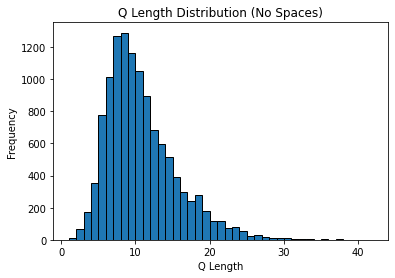

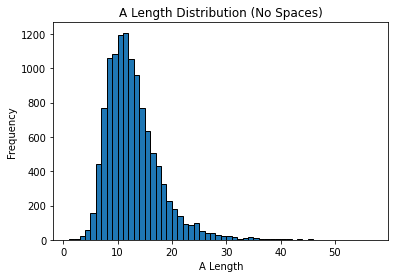

In [12]:
# que 데이터 공백 제외한 글자 길이 분포
Q = [len(sentence.replace(" ", "")) for sentence in df['Q']]

# ans 데이터 공백 제외한 글자 길이 분포
A = [len(sentence.replace(" ", "")) for sentence in df['A']]

plt.hist(Q, bins=range(1, max(Q) + 1), edgecolor='black')
plt.title("Q Length Distribution (No Spaces)")
plt.xlabel("Q Length")
plt.ylabel("Frequency")
plt.show()

plt.hist(A, bins=range(1, max(A) + 1), edgecolor='black')
plt.title("A Length Distribution (No Spaces)")
plt.xlabel("A Length")
plt.ylabel("Frequency")
plt.show()

In [13]:
max(Q),max(A)
# sequnece cutting 없음 전부 사용

(42, 57)

In [274]:
def build_corpus(source_sentences, target_sentences, max_len=57):
    """
    소스 및 타겟 데이터를 정제하고 중복을 제거하며 병렬 쌍을 유지.
    1. ans_corpus 중복인 데이터들 인덱스 저장 후 제거
    2. que_corpus 중복인 데이터들 인덱스 저장 후 제거
    """
    # 전처리된 문장 저장
    processed_pairs = []

    for src, tgt in zip(source_sentences, target_sentences):
        # 전처리
        src = preprocess_sentence(src)
        tgt = preprocess_sentence(tgt)

        # 길이 필터링
        if len(src.split()) <= max_len and len(tgt.split()) <= max_len:
            processed_pairs.append((src, tgt))

    # 1단계: ans_corpus 중복 제거
    seen_tgt = {}
    tgt_indices_to_keep = set()

    for idx, (src, tgt) in enumerate(processed_pairs):
        if tgt not in seen_tgt:
            seen_tgt[tgt] = idx
            tgt_indices_to_keep.add(idx)
        else:
            # 이전에 중복된 첫 번째 인덱스는 유지
            tgt_indices_to_keep.add(seen_tgt[tgt])

    # ans_corpus 중복 제거 후
    processed_pairs = [pair for idx, pair in enumerate(processed_pairs) if idx in tgt_indices_to_keep]

    # 2단계: que_corpus 중복 제거
    seen_src = {}
    src_indices_to_keep = set()

    for idx, (src, tgt) in enumerate(processed_pairs):
        if src not in seen_src:
            seen_src[src] = idx
            src_indices_to_keep.add(idx)
        else:
            # 이전에 중복된 첫 번째 인덱스는 유지
            src_indices_to_keep.add(seen_src[src])

    # que_corpus 중복 제거 후
    processed_pairs = [pair for idx, pair in enumerate(processed_pairs) if idx in src_indices_to_keep]

    # 소스와 타겟 데이터 분리
    src_processed = [pair[0] for pair in processed_pairs]
    tgt_processed = [pair[1] for pair in processed_pairs]

    return src_processed, tgt_processed

# build_corpus 함수 실행
que_corpus, ans_corpus = build_corpus(df['Q'], df['A'])

# 결과 확인
print("질문 데이터 (que_corpus):", que_corpus[:5])
print("응답 데이터 (ans_corpus):", ans_corpus[:5])
print("que_corpus length", len(que_corpus))
print("ans_corpus length", len(ans_corpus))

질문 데이터 (que_corpus): ['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', 'ppl 심하네', 'sd카드 망가졌어']
응답 데이터 (ans_corpus): ['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .', '다시 새로 사는 게 마음 편해요 .']
que_corpus length 7725
ans_corpus length 7725


In [275]:
from sklearn.model_selection import train_test_split

# 0.05%만 테스트 데이터로 
train_que, test_que, train_ans, test_ans = train_test_split(que_corpus, ans_corpus, test_size=0.05, random_state=2024)

print("que:", len(que_corpus))
print("ans:", len(ans_corpus))
print("train_que:", len(train_que), "train_ans:", len(train_ans))
print("test_que:", len(test_que), "test_ans:", len(test_ans))

print("train_que[:5]:", train_que[:5])
print("train_ans[:5]:", train_ans[:5])
print("test_que[:5]:", test_que[:5])
print("test_ans[:5]:", test_ans[:5])

que: 7725
ans: 7725
train_que: 7338 train_ans: 7338
test_que: 387 test_ans: 387
train_que[:5]: ['오늘밤은 비가 내립니다', '짝녀가 좋아하는 사람이 있답니다 .', '이러다 병걸리겠어', '데이트중에 정적 있어도 괜찮을까 ?', '그런 친구 아니었는데 너무 귀찮게 하네']
train_ans[:5]: ['그러게요 . 비가 추적추적 내리네요 .', '그것 참 안됐군요 .', '아프면 안 돼요 . 그럼 제 마음이 아파요 .', '정적이 있을 때 아무렇지도 않으면 편안해진 거예요 .', '친구가 좋아하나봐요 .']
test_que[:5]: ['동호회 나가기 귀찮아', '쉬고 싶은데 회식 가야돼', '후아 힘드네', '무릎 안 좋으면 스쿼트 하면 안되겠지 ?', '차단당했네']
test_ans[:5]: ['오늘은 쉬세요 .', '일과 일상 사이에서 균형이 잘 맞길 바랄게요 .', '힘내라는 진부한 말 건네봅니다 .', '무릎에 무리가 갈 거예요 .', '잊는 데는 더 도움이 될지도 몰라요 .']


In [276]:
from konlpy.tag import Mecab

# Mecab 인스턴스 생성
mecab = Mecab()

# train 토큰화 
def tokenize_corpus(source_sentences, target_sentences, tokenizer):
    
    src_tokens = [tokenizer(sentence) for sentence in source_sentences]
    tgt_tokens = [tokenizer(sentence) for sentence in target_sentences]
    
    return src_tokens, tgt_tokens

# 토큰화
que_tokens, ans_tokens = tokenize_corpus(train_que, train_ans, mecab.morphs)

# 결과 확인
print("que_corpus:", train_que[:5])
print("ans_corpus:", train_ans[:5])

que_corpus: ['오늘밤은 비가 내립니다', '짝녀가 좋아하는 사람이 있답니다 .', '이러다 병걸리겠어', '데이트중에 정적 있어도 괜찮을까 ?', '그런 친구 아니었는데 너무 귀찮게 하네']
ans_corpus: ['그러게요 . 비가 추적추적 내리네요 .', '그것 참 안됐군요 .', '아프면 안 돼요 . 그럼 제 마음이 아파요 .', '정적이 있을 때 아무렇지도 않으면 편안해진 거예요 .', '친구가 좋아하나봐요 .']


In [82]:
# !unzip ko.zip

In [83]:
ko_model = gensim.models.Word2Vec.load('/aiffel/aiffel/transformer_chatbot/ko.bin')

In [84]:
ko_model.wv.most_similar("땡")

[('끗', 0.4519278407096863),
 ('두면', 0.42365697026252747),
 ('경음', 0.4034014642238617),
 ('ㅋ', 0.398428738117218),
 ('파열음', 0.39511895179748535),
 ('홀소리', 0.3928065598011017),
 ('강호', 0.39152422547340393),
 ('비원', 0.3904140591621399),
 ('음수', 0.3901618421077728),
 ('장지', 0.3887813091278076)]

### 유의어 대체

In [277]:
def lexical_sub_with_pos(sentence, wv, num_words=4):
    """
    문장에서 특정 품사(명사, 형용사, 동사)만 랜덤하게 선택하여 유사한 단어로 대체.
    """
    mecab = Mecab()
    tokens_with_pos = mecab.pos(sentence)
    
    # 명사, 형용사, 동사, 부사만 추출
    valid_tokens = [word for word, pos in tokens_with_pos if pos in ('NNG', 'NNP', 'VA', 'VV','MAG')]

    # 선택 가능한 단어 수 제한
    num_words = min(num_words, len(valid_tokens))
    selected_tokens = random.sample(valid_tokens, num_words) if valid_tokens else []

    tokens = [word for word, _ in tokens_with_pos]  # 원본 문장 토큰화
    
    try:
        for selected_tok in selected_tokens:
            # 선택된 단어와 가장 유사한(유사도가 가장 높은) 단어 검색
            similar_word = wv.most_similar(selected_tok)[0][0]
            
            # 선택된 단어를 유사한 단어로 대체 (첫 번째로 매칭된 단어만 변경)
            for i, word in enumerate(tokens):
                if word == selected_tok:
                    tokens[i] = similar_word
                    break
    except KeyError:
        # 선택된 단어가 Word2Vec 모델에 없을 경우 원래 문장 반환
        return sentence

    return " ".join(tokens)

# 증강
def augment_corpus_with_pos(train_que, train_ans, wv, num_words=4):

    augmented_data = []

    for que, ans in zip(train_que, train_ans):
        # 원본 병렬 데이터
        augmented_data.append((que, ans))
        
        # train_que를 Augmentation
        aug_que = lexical_sub_with_pos(que, wv, num_words=num_words)
        if aug_que:
            augmented_data.append((aug_que, ans))
        
        # train_ans를 Augmentation
        aug_ans = lexical_sub_with_pos(ans, wv, num_words=num_words)
        if aug_ans:
            augmented_data.append((que, aug_ans))

    return augmented_data

In [278]:
# lexical 증강 데이터 생성

augmented_data_lexical = augment_corpus_with_pos(train_que, train_ans, ko_model.wv, num_words=4)

for que, ans in augmented_data_lexical:
    print(f"Q: {que} \nA: {ans}\n")

Q: 오늘밤은 비가 내립니다 
A: 그러게요 . 비가 추적추적 내리네요 .

Q: 아침 저녁 은 빌 가 내립니다 
A: 그러게요 . 비가 추적추적 내리네요 .

Q: 오늘밤은 비가 내립니다 
A: 그러게요 . 비가 추적추적 내리네요 .

Q: 짝녀가 좋아하는 사람이 있답니다 . 
A: 그것 참 안됐군요 .

Q: 쌍 녀 가 괜찮 아 시키 는 사람 이 없 답니다 . 
A: 그것 참 안됐군요 .

Q: 짝녀가 좋아하는 사람이 있답니다 . 
A: 그것 잊 못가 됐 군요 .

Q: 이러다 병걸리겠어 
A: 아프면 안 돼요 . 그럼 제 마음이 아파요 .

Q: 이러다 중풍 매달리 겠 어 
A: 아프면 안 돼요 . 그럼 제 마음이 아파요 .

Q: 이러다 병걸리겠어 
A: 발르 면 못가 돼요 . 그럼 제 괴로움 이 아파요 .

Q: 데이트중에 정적 있어도 괜찮을까 ? 
A: 정적이 있을 때 아무렇지도 않으면 편안해진 거예요 .

Q: 코너 중 에 동적 없 어도 좋 을까 ? 
A: 정적이 있을 때 아무렇지도 않으면 편안해진 거예요 .

Q: 데이트중에 정적 있어도 괜찮을까 ? 
A: 동적 이 없 을 때쯤 별다르 지 도 않 으면 편안 해진 거 예요 .

Q: 그런 친구 아니었는데 너무 귀찮게 하네 
A: 친구가 좋아하나봐요 .

Q: 그런 연인 아니 었 는데 워낙 바쁘 게 시키 네 
A: 친구가 좋아하나봐요 .

Q: 그런 친구 아니었는데 너무 귀찮게 하네 
A: 연인 가 괜찮 아 시키 나 봐요 .

Q: 나도 집 사고 싶어 
A: 같이 살고 싶은 사람이 있나봐요 .

Q: 나 도 곁 타 고 싶 어 
A: 같이 살고 싶은 사람이 있나봐요 .

Q: 나도 집 사고 싶어 
A: 같 살아오 고 싶 은 젊은이 이 없 나 봐요 .

Q: 띠동갑 짝사랑하는데 괜찮을까 . 
A: 사랑에 나이가 없어요 .

Q: 띠동갑 짝사랑하는데 괜찮을까 . 
A: 사랑에 나이가 없어요 .

Q: 띠동갑 짝사랑하는데 괜찮을까 . 
A: 슬픔 에 페드 가 없었 어요 .

Q: 자장면 ? 짬뽕 ? 
A: 

Q: 친구 사이로도 못 지낼 것 같아 . 
A: 계속 생각날테니 그럴만 해요 .

Q: 연인 간의 로 도 못하 지낼 것 똑같 아 . 
A: 계속 생각날테니 그럴만 해요 .

Q: 친구 사이로도 못 지낼 것 같아 . 
A: 지속 생각날 테 니 그럴 만 해요 .

Q: 슬픈 메리크리스마스이브입니다 . 
A: 다른 곳에서 행복을 찾아봐요 .

Q: 슬픈 브라스 성탄절 이드 입니다 . 
A: 다른 곳에서 행복을 찾아봐요 .

Q: 슬픈 메리크리스마스이브입니다 . 
A: 다른 이곳 에서 사랑 을 찾아내 아 봐요 .

Q: 올릴까 말까 하다가 조언을 얻고자 올려봅니다 . 
A: 잘 오셨어요 . 말씀 해보세요 .

Q: 올릴까 말 까 시키 다가 충고 을 얻어내 고자 올려 봅니다 . 
A: 잘 오셨어요 . 말씀 해보세요 .

Q: 올릴까 말까 하다가 조언을 얻고자 올려봅니다 . 
A: 많이 놀드 셨 어요 . 답변 해 보 세요 .

Q: 기프트콘으로 선물 받았어 
A: 좋겠네요 .

Q: 기프트콘으로 선물 받았어 
A: 좋겠네요 .

Q: 기프트콘으로 선물 받았어 
A: 괜찮 겠 네요 .

Q: 물건 사는것도 힘드네 
A: 칼로리 소모가 꽤 돼요 .

Q: 물건 사는것도 힘드네 
A: 칼로리 소모가 꽤 돼요 .

Q: 물건 사는것도 힘드네 
A: 열량 낭비 가 상당히 돼요 .

Q: 언제쯤 벗어날 수 있을까 
A: 우리에게 달려있을지도 몰라요 .

Q: 언제 쯤 벗어날 수 없 을까 
A: 우리에게 달려있을지도 몰라요 .

Q: 언제쯤 벗어날 수 있을까 
A: 우리 에게 달려 있 을지 도 몰라요 .

Q: 팬미팅 갔다 왔어 
A: 성덕이네요 .

Q: 매니아 라이브 갔 다 왔 어 
A: 성덕이네요 .

Q: 팬미팅 갔다 왔어 
A: 법왕 이 네요 .

Q: 어느새 헤어진지 한달 
A: 짧진 않은 시간이에요 .

Q: 갑자기 헤어진지 한 달이 
A: 짧진 않은 시간이에요 .

Q: 어느새 헤어진지 한달 
A: 좁 진 않 은 분간 이 에요 .

Q: 실망 안시키면 좋겠다 
A: 기

Q: 잘 쉬는 방법 
A: 아무것도 안하기 .

Q: 많이 숀 는 방식 
A: 아무것도 안하기 .

Q: 잘 쉬는 방법 
A: 아무것 도 못가 시키 기 .

Q: 화창한 날씨 포근한 햇살 나는 . 
A: 행복하길 바랄게요 .

Q: 화창 한 겨울철 포근 한 황금빛 나 는 . 
A: 행복하길 바랄게요 .

Q: 화창한 날씨 포근한 햇살 나는 . 
A: 사랑 하 길 바랄게요 .

Q: 다들 우리 잘 어울린대 
A: 잘 어울리는 한 쌍이에요 .

Q: 으며 들 우리 많이 어울린대 
A: 잘 어울리는 한 쌍이에요 .

Q: 다들 우리 잘 어울린대 
A: 많이 동떨어지 는 한 겹 이 에요 .

Q: 종교가 다른 여자친구 헤어져야하나 ? 
A: 종교 큰 문제죠 .

Q: 종교적 가 다른 남자 연인 헤어져야 하나 ? 
A: 종교 큰 문제죠 .

Q: 종교가 다른 여자친구 헤어져야하나 ? 
A: 종교적 큰 문제점 죠 .

Q: 오늘도 하루 버텻구나 . 
A: 오늘도 이렇게 이겨냈어요 .

Q: 오늘도 하루 버텻구나 . 
A: 오늘도 이렇게 이겨냈어요 .

Q: 오늘도 하루 버텻구나 . 
A: 아침 도 그렇게 이겨냈 어요 .

Q: 실내 데이트 어디가 좋을까 
A: 영화관이나 쇼핑몰이 생각나네요 .

Q: 실외 코너 어디 가 괜찮 을까 
A: 영화관이나 쇼핑몰이 생각나네요 .

Q: 실내 데이트 어디가 좋을까 
A: 상영관 이나 쇼핑 이 느껴지 네요 .

Q: 맞지 않더라도 대화로 잘맞아갈수 있을까 ? 
A: 서로 배려하면 가능하죠 .

Q: 들어맞 지 않 더라도 교제 로 많이 맞 아 갈 수 없 을까 ? 
A: 서로 배려하면 가능하죠 .

Q: 맞지 않더라도 대화로 잘맞아갈수 있을까 ? 
A: 각기 존경 하 면 불가능 하 죠 .

Q: 그만 울어야지 
A: 툭툭 털고 일어나세요 .

Q: 금방 쉐 어야지 
A: 툭툭 털고 일어나세요 .

Q: 그만 울어야지 
A: 툭툭 털고 일어나세요 .

Q: 나는 더 이상 아닌거겠져 . 
A: 이별은 그런 거니까요 .

Q: 나 는 던 미

Q: 아직도 . 아직 인가보다 . 
A: 곧 끝날 거예요 .

Q: 여전히 도 . 여전히 허가 보다 . 
A: 곧 끝날 거예요 .

Q: 아직도 . 아직 인가보다 . 
A: 결국 끝날 거 예요 .

Q: 나만 이상한 사람이래 
A: 그 말을 한 사람이 가장 이상할 거예요 .

Q: 나 만 미만 한 젊은이 이래 
A: 그 말을 한 사람이 가장 이상할 거예요 .

Q: 나만 이상한 사람이래 
A: 그 말로 을 한 젊은이 이 제일 미만 할 거 예요 .

Q: 이제 모든게 퍼즐처럼 맞춰지네 
A: 곱씹어도 아픈 기억인 걸요 .

Q: 그때 모든 게 액션 처럼 맞춰 지단 
A: 곱씹어도 아픈 기억인 걸요 .

Q: 이제 모든게 퍼즐처럼 맞춰지네 
A: 곱씹어도 아픈 기억인 걸요 .

Q: 이젠 의미있는 시간을 만들어보려해 
A: 그동안 못했던 일들을 시작해보세요 .

Q: 이젠 뜻하 없 는 분간 을 꾸미 어 보 려 해 
A: 그동안 못했던 일들을 시작해보세요 .

Q: 이젠 의미있는 시간을 만들어보려해 
A: 그간 못하 했 던 월과 들 을 시작하 해 보 세요 .

Q: 2년이 지나서 첫사랑이 살던곳 지나갔는데 
A: 지나가지 말지 그랬어요 .

Q: 2 년 이 지나가 서 첫 슬픔 이 살아오 던 곳 지나갔 는데 
A: 지나가지 말지 그랬어요 .

Q: 2년이 지나서 첫사랑이 살던곳 지나갔는데 
A: 걸어가 지 말 지 그랬 어요 .

Q: 너무 배가 불러 
A: 좀 쉬세요 .

Q: 워낙 배가 가 불러 
A: 좀 쉬세요 .

Q: 너무 배가 불러 
A: 조금 숀 세요 .

Q: 그냥 궁금해 
A: 궁금할 수 있어요 .

Q: 굳이 궁금 해 
A: 궁금할 수 있어요 .

Q: 그냥 궁금해 
A: 궁금 할 수 없 어요 .

Q: 첫사랑이 떠올라 
A: 기억나면 기억나는대로 마음가는대로 그냥 놔두는게 좋은거 같아요 .

Q: 첫 슬픔 이 떠올라 
A: 기억나면 기억나는대로 마음가는대로 그냥 놔두는게 좋은거 같아요 .

Q: 첫사랑이 떠올라 
A: 기억나면 기억나는대로 마음가는대


Q: 체육대회 싫어 
A: 재미 있는 종목을 찾아보세요 .

Q: 체육부 체전 힘들 어 
A: 재미 있는 종목을 찾아보세요 .

Q: 체육대회 싫어 
A: 취미 없 는 체급 을 살펴보 세요 .

Q: 사랑의 끝은 뭘까 ? 
A: 사랑하지 않는 것이죠 .

Q: 슬픔 의 겨드랑이 은 뭘까 ? 
A: 사랑하지 않는 것이죠 .

Q: 사랑의 끝은 뭘까 ? 
A: 슬픔 하 지 않 는 것 이 죠 .

Q: 1년전 헤어진 남자한테서 연락이 왔어 
A: 헤어지면 연락 하지도 받지도 마세요 .

Q: 1 년 직전 헤어진 여자 한테서 협조 이 왔 어 
A: 헤어지면 연락 하지도 받지도 마세요 .

Q: 1년전 헤어진 남자한테서 연락이 왔어 
A: 사귀 면 협조 하 지 도 넘겨받 지 도 마세요 .

Q: 좋아하던 남자애가 여친 생겼는데 막상 아무런 느낌 안 들어 . 
A: 좋아하는 걸로 착각하고 있었을 수도 있어요 .

Q: 좋아하던 남자애가 여친 생겼는데 막상 아무런 느낌 안 들어 . 
A: 좋아하는 걸로 착각하고 있었을 수도 있어요 .

Q: 좋아하던 남자애가 여친 생겼는데 막상 아무런 느낌 안 들어 . 
A: 괜찮 아 시키 는 걸로 오인 하 고 없 었 을 수 도 있 어요 .

Q: 하루하루 너무 힘드네 
A: 다른사람에게 기대보는 건 어떨까요 .

Q: 하루하루 너무 힘드네 
A: 다른사람에게 기대보는 건 어떨까요 .

Q: 하루하루 너무 힘드네 
A: 다른 젊은이 에게 기대 보 는 건 어떨까 요 .

Q: 까아 오빠들 컴백한다 
A: 기다렸나봐요 .

Q: 까 아 언니 들 데뷔 한다 
A: 기다렸나봐요 .

Q: 까아 오빠들 컴백한다 
A: 기다렸 나 봐요 .

Q: 인형뽑기 아직도 하나 
A: 하는 사람은 하더라고요

Q: 장난감 골르 기 여전히 도 시키 나 
A: 하는 사람은 하더라고요

Q: 인형뽑기 아직도 하나 
A: 시키 는 젊은이 은 시키 더라고요

Q: 이별 참 힘드네 
A: 힘들 거라 생각해요 .

Q: 이별 참 힘드네 
A: 힘들 거라 생각해요 .

Q


Q: 짝남이랑 아직 덜 친해서 오늘 아무말 대잔치함 . 
A: 어색한 시간이었겠네요 .

Q: 짝남이랑 아직 덜 친해서 오늘 아무말 대잔치함 . 
A: 어색한 시간이었겠네요 .

Q: 짝남이랑 아직 덜 친해서 오늘 아무말 대잔치함 . 
A: 어색 한 분간 이 었 겠 네요 .

Q: 썸 탈 때 단답이나 줄임말 쓰지마 ? 
A: 아무래도 장답이나 설명이 좋겠죠 .

Q: 썸 탈 때 단답이나 줄임말 쓰지마 ? 
A: 아무래도 장답이나 설명이 좋겠죠 .

Q: 썸 탈 때 단답이나 줄임말 쓰지마 ? 
A: 아무래도 장답이나 설명이 좋겠죠 .

Q: 사랑없이 결혼 가능해 ? 
A: 나이가 들고 그렇게 하기도 하는데 살면서 생기는 정으로 사는 듯합니다 .

Q: 슬픔 없 재혼 불가능 해 ? 
A: 나이가 들고 그렇게 하기도 하는데 살면서 생기는 정으로 사는 듯합니다 .

Q: 사랑없이 결혼 가능해 ? 
A: 나이 가 부유층 고 엄청 시키 기 도 하 는 데 살아오 면서 생기 는 정 으로 사 는 듯 합니다 .

Q: 갑자기 물어봐서 당황했어 
A: 갑작스러웠나봐요 .

Q: 갑작스레 물어봐서 실망 했 어 
A: 갑작스러웠나봐요 .

Q: 갑자기 물어봐서 당황했어 
A: 갑작스러웠 나 봐요 .

Q: 남자친구가 데이트 통장을 제안하는데 어떻게 생각해 ? 
A: 합리적인 소비가 가능할 거 같아요 .

Q: 남자 연인 가 코너 통장 을 제시 하 는 데 어떻 게 판단 해 ? 
A: 합리적인 소비가 가능할 거 같아요 .

Q: 남자친구가 데이트 통장을 제안하는데 어떻게 생각해 ? 
A: 인본 적 인 연방의 가 불가능 할 거 똑같 아요 .

Q: 그놈 생일이예요 
A: 365일 중에 하루일 뿐이에요 .

Q: 그놈 즉위식 이 예요 
A: 365일 중에 하루일 뿐이에요 .

Q: 그놈 생일이예요 
A: 365 일 중 에 일주일 일 뿐 이 에요 .

Q: 이별얘기 끄저그적 
A: 뭐라도 얘기를 하면 좀 나아질 거예요 .

Q: 이별얘기 끄저그적 
A: 뭐라도 얘기를 하면 좀 나아질 거예요


Q: 사귄시간만큼의 시간이 흘렀는데도 
A: 아직 그리운 놀드 봐요 .

Q: 속에 있던 소리 다 하고고 완전 끝냈어 
A: 적어도 미련은 남지 않을 거예요 .

Q: 속 에 없 던 울음소리 으며 하 고 고 완벽 끝냈 어 
A: 적어도 미련은 남지 않을 거예요 .

Q: 속에 있던 소리 다 하고고 완전 끝냈어 
A: 최소한 복수심 은 남의 지 않 을 거 예요 .

Q: 이별일까 . ? 
A: 이별이 다가옴을 느끼나봅니다 .

Q: 이 항성 일까 . ? 
A: 이별이 다가옴을 느끼나봅니다 .

Q: 이별일까 . ? 
A: 헤어지 이 다가옴 을 드러내 나 봅니다 .

Q: 남자한테 언제 설레 ? 
A: 그런 경우가 많겠지만 흘리는 말을 한 걸 안 잊고 기억해줄 때요 .

Q: 여자 한테 어디 설레 ? 
A: 그런 경우가 많겠지만 흘리는 말을 한 걸 안 잊고 기억해줄 때요 .

Q: 남자한테 언제 설레 ? 
A: 그런 때쯤 가 수많 겠 지만 흘리 는 말 을 한 걸 못가 잊 고 기억 해 줄 때 요 .

Q: 친구랑 사랑하는 사람이 같아 
A: 사랑은 쟁취하는거예요 .

Q: 연인 랑 슬픔 하 는 젊은이 이 똑같 아 
A: 사랑은 쟁취하는거예요 .

Q: 친구랑 사랑하는 사람이 같아 
A: 슬픔 은 선언 하 는 거 예요 .

Q: 썸탈때 카톡 
A: 많이하면 좋지요 .

Q: 썸탈때 카톡 
A: 많이하면 좋지요 .

Q: 썸탈때 카톡 
A: 자주 시키 면 괜찮 지요 .

Q: 일인자가 되려면 얼마나 노력해야할까 ? 
A: 인내의 시간이 필요할 거예요 .

Q: 니퍼 가 이루어지 려면 ㄹ수록 헌신 해야 할까 ? 
A: 인내의 시간이 필요할 거예요 .

Q: 일인자가 되려면 얼마나 노력해야할까 ? 
A: 고뇌 의 분간 이 불필요 할 거 예요 .

Q: 짝남한테 고백한다 ? 안한다 ? 
A: 고백해보세요 .

Q: 쌍 남의 한테 회개 한다 ? 못가 한다 ? 
A: 고백해보세요 .

Q: 짝남한테 고백한다 ? 안한다 ? 
A: 회개 해 보 세요 .

Q: 아무래도 헤어져야 

Q: 너무 사랑해서그래서 미안하다 
A: 죄송 함 이 남의 았 나 봐요 .

Q: 떠나요 제주도 
A: 여행 좋죠 !

Q: 돌아가 요 백령도 
A: 여행 좋죠 !

Q: 떠나요 제주도 
A: 항해 괜찮 죠 !

Q: 깜깜한데 전기 안들어오네 
A: 조금만 기다리면 다시 전기가 들어올거예요 .

Q: 깜깜 한데 직류 못가 넘어오 네 
A: 조금만 기다리면 다시 전기가 들어올거예요 .

Q: 깜깜한데 전기 안들어오네 
A: 약간 만 따라가 면 곧바로 직류 가 들어올 거 예요 .

Q: 그래 이제 결정했어 
A: 좋은 결과 있을 거예요 .

Q: 그래 그때 의결 했 어 
A: 좋은 결과 있을 거예요 .

Q: 그래 이제 결정했어 
A: 괜찮 은 결과물 없 을 거 예요 .

Q: 문신하고 싶은데 후회할까 ? 
A: 나중에 후회할 수도 있을 것 같아요 .

Q: 무신 하 고 싶 은데 한탄 할까 ? 
A: 나중에 후회할 수도 있을 것 같아요 .

Q: 문신하고 싶은데 후회할까 ? 
A: 예전 에 한탄 할 수 도 없 을 것 똑같 아요 .

Q: 여자친구가 왜 화났는지 모르겠어 
A: 모르는 사실에 더 화가 나 있을 거예요 .

Q: 남자 연인 가 과연 화났 는지 몰르 겠 어 
A: 모르는 사실에 더 화가 나 있을 거예요 .

Q: 여자친구가 왜 화났는지 모르겠어 
A: 몰르 는 증거 에 던 화 가 나 없 을 거 예요 .

Q: 남자친구가 좋은데 신뢰가 안 생겨 . 
A: 시간이 좀 더 필요할 것 같아요 .

Q: 여자 연인 가 괜찮 은데 신뢰 가 못가 생겨 . 
A: 시간이 좀 더 필요할 것 같아요 .

Q: 남자친구가 좋은데 신뢰가 안 생겨 . 
A: 분간 이 조금 던 필요 할 것 똑같 아요 .

Q: 괘씸하고 분하지만 너무 그립습니다 
A: 사랑과 증오 사이에서 괴로워하시는군요 .

Q: 괘씸 하 고 극하 지만 워낙 셔틀콕 습니다 
A: 사랑과 증오 사이에서 괴로워하시는군요 .

Q: 괘씸하고 분하지만 너무 그립습니다 
A: 슬픔 과 혐오 간의 에서 괴로워 하 시 는


Q: 나를 친구로 생각 안했나봐 
A: 그런 연인 는 구르 세요 .

Q: 농구하러 가야지 
A: 운동은 뭐든 좋아요 .

Q: 배구 하 러 가 야지 
A: 운동은 뭐든 좋아요 .

Q: 농구하러 가야지 
A: 투쟁 은 뭐 든 괜찮 아요 .

Q: 성공하면 계속 좋을 줄 알았는데 
A: 성공에서 가장 어려운 것이 성공한 상태를 유지하는 거예요 .

Q: 실패 하 면 지속 괜찮 을 줄 울 았 는데 
A: 성공에서 가장 어려운 것이 성공한 상태를 유지하는 거예요 .

Q: 성공하면 계속 좋을 줄 알았는데 
A: 실패 에서 제일 어려운 것 이 성공 한 상황 를 확보 하 는 거 예요 .

Q: 임용 기다리고 있어 
A: 공부하면서 못했던 것들 해보세요 .

Q: 특채 따라가 고 있 어 
A: 공부하면서 못했던 것들 해보세요 .

Q: 임용 기다리고 있어 
A: 가르치 하 면서 못했 던 것 들 해 보 세요 .

Q: 사람 만나는 게 피곤해 
A: 그 사람을 위해 에너지를 쓰니까요 .

Q: 젊은이 마주치 는 게 지루 해 
A: 그 사람을 위해 에너지를 쓰니까요 .

Q: 사람 만나는 게 피곤해 
A: 그 젊은이 을 위해 엔트로피 를 읽 니까요 .

Q: 좋아하는 사람이 인기는 많은데 여친이 없어 . 왜 그럴까 ? 
A: 혼자가 편한 걸지도 모르지요 .

Q: 좋아하는 사람이 인기는 많은데 여친이 없어 . 왜 그럴까 ? 
A: 혼자가 편한 걸지도 모르지요 .

Q: 좋아하는 사람이 인기는 많은데 여친이 없어 . 왜 그럴까 ? 
A: 거기 가 편한 걸 선구 몰르 지요 .

Q: 너무 힘든데 조언 좀 
A: 지금은 힘들지만 아무렇지도 않아질 거예요 .

Q: 워낙 힘든데 충고 조금 
A: 지금은 힘들지만 아무렇지도 않아질 거예요 .

Q: 너무 힘든데 조언 좀 
A: 현재 은 어렵 지만 별다르 지 도 않 아 질 거 예요 .

Q: 맥주 한 캔마시며 . 
A: 답답한 속을 풀어보세요 .

Q: 음료 한 캔 먹 며 . 
A: 답답한 속을 풀어보세요 .

Q: 맥주 한 캔마시며

Q: 친분 
A: 또 다른 인연이 있기 마련이죠 .

Q: 인연 
A: 각기 다른 친분 이 없 기 마련 이 죠 .

Q: 비오면 마중 나와 주는 사람 있어서 좋다 
A: 우산 같은 사람이네요 .

Q: 빌 놀드 면 마중 나와 주 는 사람 없 어서 괜찮 다 
A: 우산 같은 사람이네요 .

Q: 비오면 마중 나와 주는 사람 있어서 좋다 
A: 매화 똑같 은 젊은이 이 네요 .

Q: 쓰레기 맞지 
A: 마음을 아프게 하면 그렇죠 .

Q: 폐수 들어맞 지 
A: 마음을 아프게 하면 그렇죠 .

Q: 쓰레기 맞지 
A: 괴로움 을 발르 게 시키 면 이렇 죠 .

Q: 오랜 연애 끝에 헤어짐을 통보 받았습니다 . 
A: 이별을 받아들일 준비도 없었는데 많이 당황했겠어요 .

Q: 오랜 성행위 겨드랑이 에 헤어짐 을 통지 넘겨받 았 습니다 . 
A: 이별을 받아들일 준비도 없었는데 많이 당황했겠어요 .

Q: 오랜 연애 끝에 헤어짐을 통보 받았습니다 . 
A: 이별 을 받아들일 추진 도 없었 었 는데 자주 실망 했 겠 어요 .

Q: 술기운에 연락했는데 . 
A: 후회하지 않길 바라요 .

Q: 술기운에 연락했는데 . 
A: 후회하지 않길 바라요 .

Q: 술기운에 연락했는데 . 
A: 한탄 하 지 않 길 원하 요 .

Q: 간통 극복하는 방법 
A: 이혼하세요 .

Q: 간음 타개 하 는 방식 
A: 이혼하세요 .

Q: 간통 극복하는 방법 
A: 약혼 하 세요 .

Q: 여친 생겼는데 호칭 어떻게 함 ? 
A: 생각나는 대로 해보세요 .

Q: 여친 생겼는데 호칭 어떻게 함 ? 
A: 생각나는 대로 해보세요 .

Q: 여친 생겼는데 호칭 어떻게 함 ? 
A: 느껴지 는 대로 해 보 세요 .

Q: 여자친구가 좋은데 믿음이 안 가 . 
A: 믿음을 하나씩 쌓아주세요 .

Q: 여자 연인 가 괜찮 은 데 생각 음 이 못가 가 . 
A: 믿음을 하나씩 쌓아주세요 .

Q: 여자친구가 좋은데 믿음이 안 가 . 
A: 신념 을 하나 씩 닦 아 주 세요 .

Q: 친구 같은

Q: 여행 왔는데 좋아하는 선물로 뭐가 괜찮을까 ? 
A: 여행지에서만 살 수 있는 걸로 골라보세요 .

Q: 항해 왔 는데 좋 아 시키 는 선물 로 뭐 가 괜찮 을까 ? 
A: 여행지에서만 살 수 있는 걸로 골라보세요 .

Q: 여행 왔는데 좋아하는 선물로 뭐가 괜찮을까 ? 
A: 여행지에서만 살 수 있는 걸로 골라보세요 .

Q: 남자친구가 준 생일선물이 너무 맘에 안 들어 . 
A: 안 준 것보다 낫죠 .

Q: 여자 연인 가 준 즉위식 선물 이 너무 드가 에 안 들 어 . 
A: 안 준 것보다 낫죠 .

Q: 남자친구가 준 생일선물이 너무 맘에 안 들어 . 
A: 못가 준 것 보다 좋 죠 .

Q: 너 누구 ? 
A: 저는 마음을 이어주는 위로봇입니다 .

Q: 너 누구 ? 
A: 저는 마음을 이어주는 위로봇입니다 .

Q: 너 누구 ? 
A: 저는 마음을 이어주는 위로봇입니다 .

Q: 오늘 혼자 영화보고 왔어 
A: 혼자하는 것도 익숙해질 거예요 .

Q: 아침 거기 다큐멘터리 살펴보 고 왔 어 
A: 혼자하는 것도 익숙해질 거예요 .

Q: 오늘 혼자 영화보고 왔어 
A: 거기 하 는 것 도 익숙 해질 거 예요 .

Q: 이별한지 10일차 점점 나아지고 있습니다 . 
A: 저랑 대화하는 게 위로가 되었으면 합니다 .

Q: 헤어지 한 지 10 일 궤조 점차 나빠지 고 있 습니다 . 
A: 저랑 대화하는 게 위로가 되었으면 합니다 .

Q: 이별한지 10일차 점점 나아지고 있습니다 . 
A: 저 랑 교제 하 는 게 무릎 가 이루어지 었 으면 합니다 .

Q: 매일 카페에서 그의 뒷모습만 보게 돼 . 
A: 이제 앞모습을 보세요 .

Q: 매일 카페에서 그의 뒷모습만 보게 돼 . 
A: 이제 앞모습을 보세요 .

Q: 매일 카페에서 그의 뒷모습만 보게 돼 . 
A: 이제 앞모습을 보세요 .

Q: 내 인생은 가시밭길 같아 
A: 꽃길만 걷길 바랍니다 .

Q: 내 인생은 가시밭길 같아 
A: 꽃길만 걷길 바랍니다 .

Q: 내 인생은 가시밭길 같아 


In [279]:
len(augmented_data_lexical)

22014

In [280]:
augmented_data_lexical[0:3]

[('오늘밤은 비가 내립니다', '그러게요 . 비가 추적추적 내리네요 .'),
 ('아침 저녁 은 빌 가 내립니다', '그러게요 . 비가 추적추적 내리네요 .'),
 ('오늘밤은 비가 내립니다', '그러게요 . 비가 추적추적 내리네요 .')]

### random_swap
* 명사-명사 or 부사-부사 or 동사-형용사

In [197]:
import time

In [260]:
def random_swap_with_pos(sentence, num_swaps=1, swap_types=['NNG-NNG', 'MAG-MAG', 'VV-VA']):
    """
    문장에서 지정된 스왑 방식 중 하나를 랜덤으로 선택하여 단어의 위치를 교환.
    :param sentence: 입력 문장
    :param num_swaps: 교환 횟수
    :param swap_types: 가능한 스왑 방식 리스트 (예: 'NNG-NNG', 'MAG-MAG', 'VV-VA')
    :return: 단어가 교환된 문장
    """
    mecab = Mecab()
    tokens_with_pos = mecab.pos(sentence)
    tokens = [word for word, _ in tokens_with_pos]  # 원본 문장 토큰화

    # 랜덤 스왑 방식 선택
    swap_type = random.choice(swap_types)
    pos1, pos2 = swap_type.split('-')

    # 첫 번째 품사에 해당하는 단어 추출
    valid_tokens_1 = [(idx, word) for idx, (word, pos) in enumerate(tokens_with_pos) if pos == pos1]
    valid_tokens_2 = [(idx, word) for idx, (word, pos) in enumerate(tokens_with_pos) if pos == pos2]

    # 교환 가능한 단어 쌍이 부족한 경우 원래 문장 반환
    if len(valid_tokens_1) < 1 or len(valid_tokens_2) < 1:
        return sentence

    # 지정된 횟수만큼 단어 위치 교환
    for _ in range(min(num_swaps, len(valid_tokens_1), len(valid_tokens_2))):
        idx1, word1 = random.choice(valid_tokens_1)
        valid_tokens_2_filtered = [token for token in valid_tokens_2 if token[0] != idx1]
        if not valid_tokens_2_filtered:
            continue
        idx2, word2 = random.choice(valid_tokens_2_filtered)

        # 위치 교환
        tokens[idx1], tokens[idx2] = tokens[idx2], tokens[idx1]

    return " ".join(tokens)

In [261]:
def augment_corpus_with_random_swap(train_que, train_ans, num_swaps=1, swap_types=['NNG-NNG', 'MAG-MAG', 'VV-VA']):
    """
    que 또는 ans를 Random Swap 방식으로 증강. tqdm을 사용하여 진행 상황 표시.
    :param train_que: 원본 질문 데이터
    :param train_ans: 원본 답변 데이터
    :param num_swaps: 교환 횟수
    :param swap_types: 가능한 스왑 방식 리스트
    :return: 증강된 데이터
    """
    augmented_data = []

    start_time = time.time() 

    with tqdm(total=len(train_que), desc="Random Swap Augmentation") as pbar:
        for que, ans in zip(train_que, train_ans):
            # 원본 데이터 
            augmented_data.append((que, ans))

            # que 고정, ans만 Random Swap 증강
            aug_ans = random_swap_with_pos(ans, num_swaps=num_swaps, swap_types=swap_types)
            augmented_data.append((que, aug_ans))

            # ans 고정, que만 Random Swap 증강
            aug_que = random_swap_with_pos(que, num_swaps=num_swaps, swap_types=swap_types)
            augmented_data.append((aug_que, ans))

            pbar.update(1)  

    end_time = time.time()  
    print(f"Total augmentation time: {end_time - start_time:.2f} seconds")

    return augmented_data

In [262]:
# Random Swap 증강 데이터 생성
augmented_data_random_swap = augment_corpus_with_random_swap(
    train_que, 
    train_ans, 
    num_swaps=1, 
    swap_types=['NNG-NNG', 'MAG-MAG', 'VV-VA']
)

for que, ans in augmented_data_random_swap[:10]:
    print(f"Q: {que} \nA: {ans}\n")

Random Swap Augmentation:   0%|          | 0/7338 [00:00<?, ?it/s]

Total augmentation time: 11.67 seconds
Q: 오늘밤은 비가 내립니다 
A: 그러게요 . 비가 추적추적 내리네요 .

Q: 오늘밤은 비가 내립니다 
A: 그러 게 요 . 비 가 추적추적 내리 네요 .

Q: 오늘밤은 비가 내립니다 
A: 그러게요 . 비가 추적추적 내리네요 .

Q: 짝녀가 좋아하는 사람이 있답니다 . 
A: 그것 참 안됐군요 .

Q: 짝녀가 좋아하는 사람이 있답니다 . 
A: 그것 참 안됐군요 .

Q: 짝녀가 좋아하는 사람이 있답니다 . 
A: 그것 참 안됐군요 .

Q: 이러다 병걸리겠어 
A: 아프면 안 돼요 . 그럼 제 마음이 아파요 .

Q: 이러다 병걸리겠어 
A: 아프 면 안 돼요 . 그럼 제 마음 이 아파요 .

Q: 이러다 병 걸리 겠 어 
A: 아프면 안 돼요 . 그럼 제 마음이 아파요 .

Q: 데이트중에 정적 있어도 괜찮을까 ? 
A: 정적이 있을 때 아무렇지도 않으면 편안해진 거예요 .



In [263]:
len(augmented_data_random_swap)

22014

### random_insertion
* 명사 앞에 word2vec 중 가장 관련도 높은  형용사 추가. 없으면 동사 앞에 word2vec 중 가장 관련도 높은 부사 추가

In [281]:
def random_insertion_with_pos(sentence, wv, valid_pos_noun='NNG', valid_pos_verb='VV', insert_pos_noun='VA', insert_pos_verb='MAG', num_insertions=1):
    """
    문장에서 명사 앞에 유의관계가 높은 형용사를 삽입하거나,
    명사가 없을 경우 동사 앞에 부사를 삽입.
    :param sentence: 입력 문장
    :param wv: Word2Vec 모델
    :param valid_pos_noun: 명사로 간주할 품사 태그
    :param valid_pos_verb: 동사로 간주할 품사 태그
    :param insert_pos_noun: 명사 앞에 삽입할 품사 태그
    :param insert_pos_verb: 동사 앞에 삽입할 품사 태그
    :param num_insertions: 삽입 횟수
    :return: 단어가 삽입된 문장
    """
    mecab = Mecab()
    tokens_with_pos = mecab.pos(sentence)

    tokens = [word for word, _ in tokens_with_pos]  # 원본 문장 토큰화

    # 명사와 동사 위치 추출
    noun_positions = [(idx, word) for idx, (word, pos) in enumerate(tokens_with_pos) if pos == valid_pos_noun]
    verb_positions = [(idx, word) for idx, (word, pos) in enumerate(tokens_with_pos) if pos == valid_pos_verb]

    # 명사가 있는 경우: 명사 앞에 형용사 삽입
    if noun_positions:
        for _ in range(min(num_insertions, len(noun_positions))):
            idx, noun = random.choice(noun_positions)
            try:
                similar_word = wv.most_similar(noun)[0][0]  # 유사 단어 검색
                tokens.insert(idx, similar_word)  # 명사 앞에 삽입
            except KeyError:
                continue  # 단어가 Word2Vec 모델에 없는 경우 무시

    # 명사가 없는 경우: 동사 앞에 부사 삽입
    elif verb_positions:
        for _ in range(min(num_insertions, len(verb_positions))):
            idx, verb = random.choice(verb_positions)
            try:
                similar_word = wv.most_similar(verb)[0][0]  # 유사 단어 검색
                tokens.insert(idx, similar_word)  # 동사 앞에 삽입
            except KeyError:
                continue  # 단어가 Word2Vec 모델에 없는 경우 무시

    return " ".join(tokens)

In [282]:
def augment_corpus_with_random_insertion(train_que, train_ans, wv, num_insertions=1):
    """
    que 또는 ans를 Random Insertion 방식으로 증강.
    :param train_que: 원본 질문 데이터
    :param train_ans: 원본 답변 데이터
    :param wv: Word2Vec 모델
    :param num_insertions: 삽입 횟수
    :return: 증강된 데이터
    """
    augmented_data = []

    with tqdm(total=len(train_que), desc="Random Insertion Augmentation") as pbar:
        for que, ans in zip(train_que, train_ans):
            # 원본 데이터 
            augmented_data.append((que, ans))

            # que 고정, ans만 Random Insertion 증강
            aug_ans = random_insertion_with_pos(ans, wv, num_insertions=num_insertions)
            augmented_data.append((que, aug_ans))

            # ans 고정, que만 Random Insertion 증강
            aug_que = random_insertion_with_pos(que, wv, num_insertions=num_insertions)
            augmented_data.append((aug_que, ans))

            pbar.update(1) 

    return augmented_data

In [283]:
# Random Insertion 증강 데이터 생성
augmented_data_random_insertion = augment_corpus_with_random_insertion(
    train_que, train_ans, ko_model.wv, num_insertions=1
)

for que, ans in augmented_data_random_insertion[:10]:
    print(f"Q: {que} \nA: {ans}\n")

Random Insertion Augmentation:   0%|          | 0/7338 [00:00<?, ?it/s]

Q: 오늘밤은 비가 내립니다 
A: 그러게요 . 비가 추적추적 내리네요 .

Q: 오늘밤은 비가 내립니다 
A: 그러 게 요 . 빌 비 가 추적추적 내리 네요 .

Q: 오늘 밤 은 빌 비 가 내립니다 
A: 그러게요 . 비가 추적추적 내리네요 .

Q: 짝녀가 좋아하는 사람이 있답니다 . 
A: 그것 참 안됐군요 .

Q: 짝녀가 좋아하는 사람이 있답니다 . 
A: 그것 참 안 됐 군요 .

Q: 쌍 짝 녀 가 좋 아 하 는 사람 이 있 답니다 . 
A: 그것 참 안됐군요 .

Q: 이러다 병걸리겠어 
A: 아프면 안 돼요 . 그럼 제 마음이 아파요 .

Q: 이러다 병걸리겠어 
A: 아프 면 안 돼요 . 그럼 제 괴로움 마음 이 아파요 .

Q: 이러다 중풍 병 걸리 겠 어 
A: 아프면 안 돼요 . 그럼 제 마음이 아파요 .

Q: 데이트중에 정적 있어도 괜찮을까 ? 
A: 정적이 있을 때 아무렇지도 않으면 편안해진 거예요 .



### 데이터 셋 sequence가 짧은 관계로 Random Deletion은 진행 X

In [284]:
# 증강 데이터셋 merge
# augmented_data_random_swap 
augmented_data = augmented_data_lexical + augmented_data_random_insertion

# 중복 제거 
augmented_data = list(set(augmented_data))

In [285]:
len(augmented_data)

34024

In [232]:
augmented_data[0:3]

[('한 번 은 던 볼 월과 이 없 을 것 똑같 았 는데 .', '살면서 볼 수도 있겠죠 .'),
 ('맘이 아푸네', '아프지마요 .'),
 ('이별을 준비하고 있습니다 .', '어렵 지 않 을 의결 이 었 을 텐데 .')]

In [286]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ans_corpus에 <start>와 <end> 토큰 추가
augmented_data_with_tokens = [
    (que, f"<start> {ans} <end>") for que, ans in augmented_data
]

# que_corpus와 ans_corpus 분리
train_que = [data[0] for data in augmented_data_with_tokens]
train_ans = [data[1] for data in augmented_data_with_tokens]

# 단어 사전 생성 (Tokenizer)
tokenizer = Tokenizer(filters='', oov_token="<unk>")
tokenizer.fit_on_texts(train_que + train_ans)

# 텍스트 벡터화 
que_sequences = tokenizer.texts_to_sequences(train_que)
ans_sequences = tokenizer.texts_to_sequences(train_ans)

# 패딩
# max_len_que = max(len(seq) for seq in que_sequences)
# max_len_ans = max(len(seq) for seq in ans_sequences)
# 계산결과 최대가 42임. 데이터 size가 작은 관계로 que-ans 통일 
MAX_LEN = 42

# 인코더 - 디코더 분리
enc_train = pad_sequences(que_sequences, maxlen=MAX_LEN, padding="post")
dec_train = pad_sequences(ans_sequences, maxlen=MAX_LEN, padding="post")

# vocab size
VOCAB_SIZE = len(tokenizer.word_index) + 1  # 패딩 토큰

print(f"vocab_size: {VOCAB_SIZE}")
print(f"enc_train.shape: {enc_train.shape}")
print(f"dec_train.shape: {dec_train.shape}")

vocab_size: 22243
enc_train.shape: (34024, 42)
dec_train.shape: (34024, 42)


In [287]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).batch(batch_size=BATCH_SIZE)

In [288]:
# 데이터로더 차원 확인
for enc_batch, dec_batch in train_dataset.take(1):
    print(f"enc_batch.shape: {enc_batch.shape}") 
    print(f"dec_batch.shape: {dec_batch.shape}") 

enc_batch.shape: (64, 42)
dec_batch.shape: (64, 42)


### 모델 구축

In [30]:
# 포지셔널 인코딩
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [31]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [32]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions

    def split_heads(self, x):
        bsz = tf.shape(x)[0]  # 배치 크기
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = tf.shape(x)[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [33]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

In [34]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [35]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [36]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [37]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [118]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        # 인코더 디코더 임베딩 공유
        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc
        # 디코더 출력 FC 임베딩 공유
        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [119]:
# 마스크 차원 확인
enc_mask, dec_enc_mask, dec_mask = generate_masks(enc_batch, dec_batch)
print(f"enc_mask.shape: {enc_mask.shape}")
print(f"dec_enc_mask.shape: {dec_enc_mask.shape}")
print(f"dec_mask.shape: {dec_mask.shape}")

enc_mask.shape: (64, 1, 1, 42)
dec_enc_mask.shape: (64, 1, 1, 42)
dec_mask.shape: (64, 1, 42, 42)


In [289]:
transformer = Transformer(
    n_layers=6,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

In [290]:
# Functional API
enc_input = tf.keras.Input(shape=(42,), dtype=tf.int32, name="enc_input")
dec_input = tf.keras.Input(shape=(42,), dtype=tf.int32, name="dec_input")
enc_mask = tf.keras.Input(shape=(1, 1, 42), dtype=tf.float32, name="enc_mask")
dec_enc_mask = tf.keras.Input(shape=(1, 1, 42), dtype=tf.float32, name="dec_enc_mask")
dec_mask = tf.keras.Input(shape=(1, 42, 42), dtype=tf.float32, name="dec_mask")

# Transformer 담기
logits, enc_attns, dec_attns, dec_enc_attns = transformer(
    enc_in=enc_input,
    dec_in=dec_input,
    enc_mask=enc_mask,
    dec_enc_mask=dec_enc_mask,
    dec_mask=dec_mask
)

# 모델 생성
transformer_model = tf.keras.Model(
    inputs=[enc_input, dec_input, enc_mask, dec_enc_mask, dec_mask],
    outputs=logits,
    name="Transformer"
)

# 모델 summary
transformer_model.summary()

Model: "Transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_input (InputLayer)          [(None, 42)]         0                                            
__________________________________________________________________________________________________
dec_enc_mask (InputLayer)       [(None, 1, 1, 42)]   0                                            
__________________________________________________________________________________________________
dec_input (InputLayer)          [(None, 42)]         0                                            
__________________________________________________________________________________________________
dec_mask (InputLayer)           [(None, 1, 42, 42)]  0                                            
________________________________________________________________________________________

In [291]:
d_model = 512
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [292]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [293]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

Starting epoch 1/15...


  0%|          | 0/532 [00:00<?, ?it/s]

Epoch 1 Loss: 6.1610
Starting epoch 2/15...


  0%|          | 0/532 [00:00<?, ?it/s]

Epoch 2 Loss: 4.1900
Starting epoch 3/15...


  0%|          | 0/532 [00:00<?, ?it/s]

Epoch 3 Loss: 2.7629
Starting epoch 4/15...


  0%|          | 0/532 [00:00<?, ?it/s]

Epoch 4 Loss: 1.9385
Starting epoch 5/15...


  0%|          | 0/532 [00:00<?, ?it/s]

Epoch 5 Loss: 1.6364
Starting epoch 6/15...


  0%|          | 0/532 [00:00<?, ?it/s]

Epoch 6 Loss: 1.4717
Starting epoch 7/15...


  0%|          | 0/532 [00:00<?, ?it/s]

Epoch 7 Loss: 1.3742
Starting epoch 8/15...


  0%|          | 0/532 [00:00<?, ?it/s]

Epoch 8 Loss: 1.3048
Starting epoch 9/15...


  0%|          | 0/532 [00:00<?, ?it/s]

Epoch 9 Loss: 1.1275
Starting epoch 10/15...


  0%|          | 0/532 [00:00<?, ?it/s]

Epoch 10 Loss: 0.9470
Starting epoch 11/15...


  0%|          | 0/532 [00:00<?, ?it/s]

Epoch 11 Loss: 0.8072
Starting epoch 12/15...


  0%|          | 0/532 [00:00<?, ?it/s]

Epoch 12 Loss: 0.7002
Starting epoch 13/15...


  0%|          | 0/532 [00:00<?, ?it/s]

Epoch 13 Loss: 0.6224
Starting epoch 14/15...


  0%|          | 0/532 [00:00<?, ?it/s]

Epoch 14 Loss: 0.5525
Starting epoch 15/15...


  0%|          | 0/532 [00:00<?, ?it/s]

Epoch 15 Loss: 0.4902


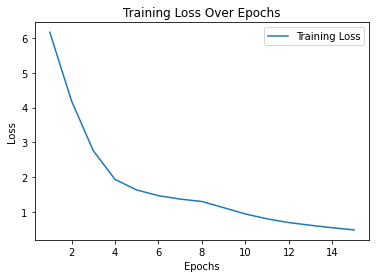

In [294]:
# 손실 기록을 위한 리스트
train_losses = []

# 학습 시작
EPOCHS = 15

for epoch in range(EPOCHS):
    print(f"Starting epoch {epoch + 1}/{EPOCHS}...")
    total_loss = 0  # 손실 초기화

    # 데이터셋 count
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)  
    # batch 당 손실 계산 & 업데이트
    for batch, (src, tgt) in enumerate(train_dataset):

        batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(src, tgt, transformer, optimizer)
        total_loss += batch_loss  

        tqdm_bar.set_description(f"Epoch {epoch + 1}/{EPOCHS}")  
        tqdm_bar.set_postfix(loss=batch_loss.numpy())  
        tqdm_bar.update(1)  

    tqdm_bar.close()  

    # meal Loss
    epoch_loss = total_loss / dataset_count
    train_losses.append(epoch_loss)  
    print(f"Epoch {epoch + 1} Loss: {epoch_loss:.4f}")

plt.plot(range(1, EPOCHS + 1), train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

In [50]:
test_que,test_ans

(['동호회 나가기 귀찮아',
  '쉬고 싶은데 회식 가야돼',
  '후아 힘드네',
  '무릎 안 좋으면 스쿼트 하면 안되겠지 ?',
  '차단당했네',
  '보기만해도 짜증이 나지',
  '허허 맴찢 .',
  '이별의 아픔이 있는데 몸까지 아파서야',
  '완전히 정리했어',
  '배에서 꾸룩꾸룩 소리 남',
  '좋아하는 감정이 뭐예요 ?',
  '사표 낼까 ?',
  '일 하면서 알게 된 사람한테 연락해도 될까 ?',
  '짝남에게 밤에 자주 산책하자고 해도될까 ?',
  '살만해 ?',
  '대학 가고 싶다 .',
  '또 전화 안받아',
  '이런 일상에서 휙 떠나고 싶어',
  '맥주 마셔야지',
  '환승이였다는걸 알고서 .',
  '나 윗집 남자애 좋아하는 것 같애 .',
  '너한테 이글안보여줄거다 .',
  '다른 사람들에 비해 만남은 짧앗지만',
  '마음만은 청춘이야',
  '사랑은 영원해 ?',
  '이별 너무 힘드네',
  '역류성 식도염 온 거 같아 .',
  '붙잡으려고',
  '아닌건 아니다',
  '사랑이 뭐가 대수라고',
  '삼겹살 냄새',
  '짝남이 자꾸 꿈에 나오는데 꿈에서도 용기 없어서 피하고 그래 .',
  '결혼을 앞두고 있습니다',
  '사랑하는 사람이 있어',
  '내가 그사람한테 필요했으면 좋겠어',
  '울면서 카톡 보냈어 너무 힘들어서',
  '수업시간 내내 잤어',
  '숨막히는건 없어졌네',
  '두달이 되가네 .',
  '오늘도 어김없이 너무생각나네',
  '남자친구가 나한테 너무 집착해',
  '파혼한거 정말 잘했다',
  '하품 나와',
  '반년만에 연락해봤네',
  '그 사람이 나 안 좋아하는 거 같아',
  '군대 언제 끝나나',
  '억울한 현실',
  '남자친구가 너무 좋아',
  '아주 잊기로 독하게 마음 먹고 신나게 놀고 있습니다',
  'sd카드 망가졌어',
  '오늘부터 내려놓기로 했습니다 .',
  '참 힘드네',
  '오늘 왤케 추워',
  '그 사람도 그럴까 ? ?',
 

In [295]:
# 정성평가
def predict_sentence(question, model, tokenizer, max_len=42):

    # 질문 전처리
    question = preprocess_sentence(question)
    question_seq = tokenizer.texts_to_sequences([question])
    question_seq = pad_sequences(question_seq, maxlen=max_len, padding='post')
    
    # 초기 디코더 입력
    start_token = tokenizer.word_index["<start>"]
    end_token = tokenizer.word_index["<end>"]
    decoder_input = [start_token]
    output = []
    
    for _ in range(max_len):
        decoder_input_padded = pad_sequences([decoder_input], maxlen=max_len, padding='post')
        
        # 마스크 생성
        enc_mask, dec_enc_mask, dec_mask = generate_masks(
            tf.constant(question_seq), tf.constant(decoder_input_padded)
        )
        
        # 예측
        predictions, _, _, _ = model(
            tf.constant(question_seq), 
            tf.constant(decoder_input_padded), 
            enc_mask, 
            dec_enc_mask, 
            dec_mask
        )
        
        # 가장 높은 확률의 단어 선택
        next_token = tf.argmax(predictions[0, len(decoder_input) - 1]).numpy()
        if next_token == end_token:  # <end> 토큰이면 중단
            break
        
        decoder_input.append(next_token)
        output.append(next_token)
    
    # 인덱스를 단어로 변환
    return tokenizer.sequences_to_texts([output])[0]

In [296]:
# n-gram 기반 metrics 
# test 셋 검증을 위함 - 위 코드와 구조적으로 동일
def evaluate_metrics(predictions, references):
    """
    BLEU 및 ROUGE 점수를 계산합니다.
    :param predictions: 모델이 생성한 텍스트 리스트
    :param references: 실제 정답 텍스트 리스트
    :return: BLEU 및 ROUGE 점수
    """
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    from rouge_score import rouge_scorer

    # BLEU 점수 계산
    bleu_scores = []
    smooth_fn = SmoothingFunction().method1  # BLEU 점수 스무딩 함수
    for pred, ref in zip(predictions, references):
        bleu = sentence_bleu([ref.split()], pred.split(), smoothing_function=smooth_fn)
        bleu_scores.append(bleu)

    avg_bleu = sum(bleu_scores) / len(bleu_scores)

    # ROUGE 점수 계산
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    for pred, ref in zip(predictions, references):
        scores = rouge.score(ref, pred)
        for key in rouge_scores:
            rouge_scores[key].append(scores[key].fmeasure)

    avg_rouge = {key: sum(rouge_scores[key]) / len(rouge_scores[key]) for key in rouge_scores}

    return avg_bleu, avg_rouge


def predict_responses(test_que, model, tokenizer, max_len):
    """
    테스트 질문 데이터를 입력으로 모델이 예측한 답변을 생성합니다.
    진행 과정을 tqdm으로 표시합니다.
    :param test_que: 테스트 질문 데이터
    :param model: Transformer 모델
    :param tokenizer: 토크나이저
    :param max_len: 최대 시퀀스 길이
    :return: 모델이 생성한 답변 리스트
    """
    predictions = []

    for que in tqdm(test_que, desc="Predicting Responses"):
        # que 토큰화 및 패딩
        que_seq = tokenizer.texts_to_sequences([que])
        que_seq = pad_sequences(que_seq, maxlen=max_len, padding='post')

        # 디코더 입력 초기화 (<start> 토큰 사용)
        dec_input = [[tokenizer.word_index['<start>']]]
        for _ in range(max_len):
            dec_input_padded = pad_sequences(dec_input, maxlen=max_len, padding='post')

            # 마스크 생성
            enc_mask = generate_padding_mask(tf.constant(que_seq))
            dec_enc_mask = generate_padding_mask(tf.constant(que_seq))
            dec_mask = generate_lookahead_mask(dec_input_padded.shape[1])
            dec_mask = tf.maximum(dec_mask, generate_padding_mask(tf.constant(dec_input_padded)))

            # 모델 예측
            logits = model(
                [tf.constant(que_seq), tf.constant(dec_input_padded), enc_mask, dec_enc_mask, dec_mask]
            )

            # 가장 높은 확률을 가진 단어 선택
            next_word = tf.argmax(logits[:, len(dec_input[0]) - 1, :], axis=-1).numpy()[0]
            if next_word == tokenizer.word_index['<end>']:
                break

            dec_input[0].append(next_word)

        # 디코더 입력을 텍스트로 변환
        pred_sentence = tokenizer.sequences_to_texts(dec_input)[0].replace('<start>', '').replace('<end>', '').strip()
        predictions.append(pred_sentence)

    return predictions

#### 러닝커브 각 에폭에서 비교


In [297]:
questions = ["무릎 안 좋으면 스쿼트 하면 안되겠지 ?", "나 윗집 남자애 좋아하는 것 같애 .", "짝남이 자꾸 꿈에 나오는데 꿈에서도 용기 없어서 피하고 그래 .", "2년동안 나 사랑해줘서 고맙다", "내가 친절하니까 쉬워보이나 ?"]

for question in questions:
    answer = predict_sentence(question, transformer, tokenizer)
    print(f"Q: {question}")
    print(f"A: {answer}")
    print()

Q: 무릎 안 좋으면 스쿼트 하면 안되겠지 ?
A: 저는 신경 신경 안 같아요 .

Q: 나 윗집 남자애 좋아하는 것 같애 .
A: 괴로움 마음 이 언제나 단지 지도 몰라요 .

Q: 짝남이 자꾸 꿈에 나오는데 꿈에서도 용기 없어서 피하고 그래 .
A: 함부로 옷을 잘 안되겠지만 잘할 수 있을 거예요 .

Q: 2년동안 나 사랑해줘서 고맙다
A: 잊어버리 는 분간 이 불필요 했 나 봐요 .

Q: 내가 친절하니까 쉬워보이나 ?
A: 항상 사랑했던 걸 수도 있어요 .



In [299]:
# test에 대한 예측(ans) 
predictions = predict_responses(test_que, transformer_model, tokenizer, MAX_LEN)

Predicting Responses:   0%|          | 0/387 [00:00<?, ?it/s]

In [300]:
# BLEU 점수 계산

smooth_fn = SmoothingFunction().method1  # BLEU 스무딩 

references = [[ans.split()] for ans in tqdm(test_ans, desc="Processing BLEU References")]
predictions_split = [pred.split() for pred in tqdm(predictions, desc="Processing BLEU Predictions")]

bleu_score = corpus_bleu(
    references,
    predictions_split,
    smoothing_function=smooth_fn
)

print(f"BLEU Score: {bleu_score:.4f}")

Processing BLEU References:   0%|          | 0/387 [00:00<?, ?it/s]

Processing BLEU Predictions:   0%|          | 0/387 [00:00<?, ?it/s]

BLEU Score: 0.0008


In [301]:
# ROUGE 점수 계산

rouge_scorer_instance = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []} # n-gram 기반

for pred, ref in tqdm(zip(predictions, test_ans), total=len(test_ans), desc="Calculating ROUGE"):
    scores = rouge_scorer_instance.score(ref, pred)  # 각 문장에 대해 ROUGE 계산
    for key in rouge_scores:
        rouge_scores[key].append(scores[key].fmeasure)

avg_rouge_score = {key: sum(rouge_scores[key]) / len(rouge_scores[key]) for key in rouge_scores}

print(f"ROUGE Score: {avg_rouge_score}")

INFO:absl:Using default tokenizer.


Calculating ROUGE:   0%|          | 0/387 [00:00<?, ?it/s]

ROUGE Score: {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}


#### n-gram으로 맞춰서 precision이나 recall을 측정하는건 사실상 언어, 특히 생성 task에 맞지 않는다. 
* 단어의 유사도, 즉 문맥 자체를 바라볼 수 있는 metric이 필요하다. 

In [302]:
# KoBERTScore 계산

with tqdm(total=len(predictions), desc="Processing KoBERTScore") as pbar:
    P, R, F1 = score(predictions, test_ans, lang="ko", verbose=True)
    pbar.update(len(predictions))

print(f"KoBERTScore - Precision: {P.mean().item():.4f}, Recall: {R.mean().item():.4f}, F1: {F1.mean().item():.4f}")

Calculating KoBERTScore...


Processing KoBERTScore:   0%|          | 0/387 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/11 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 0.95 seconds, 406.96 sentences/sec
KoBERTScore - Precision: 0.7209, Recall: 0.7281, F1: 0.7241


### 문맥의 유사도에 기반하는 KoBERTScore가 챗봇 대화 생성 task에서 적절한 평가 metric이 될 것이다.
### 이해나 직관적으로도 가장 납득이 되며, 적은 데이터의 양과 도메인에 큰 영향을 받는 task이기에 특히나 유사도를 기반으로 맥락을 파악하는 것이 적절할 것이다.

#### KoBERTScore를 정량 metric으로 잡고 test que의 예문 5개를 기반하여 정성적 평가를 같이 진행

#### 1. 데이터 22000개(mecab - 'VA', 'VV','MAG' 중 최대 2개 변경하여 증강한 데이터셋 ), layer 6개, 15 epoch
* train Loss : Loss: 1.1009, KoBERTScore - Precision: 0.7071, Recall: 0.7176, F1: 0.7119

#### 2. 데이터 22000개(mecab - 'VA', 'VV','MAG' 중 최대 3개 변경하여 증강한 데이터셋 ), 6 layer, 15 epoch
* train Loss : Loss: 1.0342, KoBERTScore - Precision: 0.7224, Recall: 0.7251, F1: 0.7233

#### 3. 데이터 22000개(mecab -'NNG', 'NNP', 'VA', 'VV','MAG' 중 최대 3개 변경하여 증강한 데이터셋 ), 6 layer, 15 epoch
* train Loss : Loss: 1.0237, KoBERTScore - Precision: 0.7290, Recall: 0.7231, F1: 0.7256

#### 4. 데이터 22000개(mecab -'NNG', 'NNP', 'VA', 'VV','MAG' 중 최대 4개 변경하여 증강한 데이터셋 ), 6 layer, 15 epoch
* train Loss : Loss: 1.0237, KoBERTScore - Precision: 0.7332, Recall: 0.7251, F1: 0.7286

#### 5. 데이터 22000개(mecab -'NNG', 'NNP', 'VA', 'VV','MAG' 중 최대 5개 변경하여 증강한 데이터셋 ), 6 layer, 15 epoch
* train Loss : Loss: 1.0489, KoBERTScore - Precision: 0.7112, Recall: 0.7202, F1: 0.7151
* 단지 불순물이 더 많이 낀 탓에 학습이 더 필요할수도 있는 상황
* Q: 무릎 안 좋으면 스쿼트 하면 안되겠지 ?
* A: 따로 신경쓰이는 부분이 없다면 가능합니다 .

* Q: 나 윗집 남자애 좋아하는 것 같애 .
* A: 충분히 지칠만 해요 .

* Q: 짝남이 자꾸 꿈에 나오는데 꿈에서도 용기 없어서 피하고 그래 .
* A: 자신감 을 자주 힘든가 봐요 .

* Q: 2년동안 나 사랑해줘서 고맙다
* A: 충분히 지칠만 해요 .

* Q: 내가 친절하니까 쉬워보이나 ?
* A: cc는 자들의 변명이에요 .

### 위 실험 중 KoBERTScore가 가장 높았던 4번을 기준으로 잡고 추가 생성 task 진행

#### 데이터 26000개(4번 유의어변경 + random_swap 'NNG-NNG', 'MAG-MAG', 'VV-VA') 중 1쌍 변경
* train Loss : Loss: 0.6049, KoBERTScore - Precision: 0.7208, Recall: 0.7276, F1: 0.7238
* Q: 무릎 안 좋으면 스쿼트 하면 안되겠지 ?
* A: 이성으로 입히 없네요 .

* Q: 나 윗집 남자애 좋아하는 것 같애 .
* A: 각자가 생각하는 기본이 사랑하지 않는 어플을 읽히 겠 어요 .

* Q: 짝남이 자꾸 꿈에 나오는데 꿈에서도 용기 없어서 피하고 그래 .
* A: 의심 해도 시키 니까요 .

* Q: 2년동안 나 사랑해줘서 고맙다
* A: 저 는 힘 이 되 고 기분 에 연락 을 찾 는 게 만들 어 보 세요 .

* Q: 내가 친절하니까 쉬워보이나 ?
* A: 서로의 선에 대해 됩니다 .

#### 데이터 34000개(4번 유의어 변경 + random_insertion 명사 앞에 형용사 or 동사 앞에 부사 6 layer, 15 epoch
* train Loss : Loss: 0.4902, KoBERTScore - Precision: 0.7209, Recall: 0.7281, F1: 0.7241
* Q: 무릎 안 좋으면 스쿼트 하면 안되겠지 ?
* A: 저는 신경 신경 안 같아요 .

* Q: 나 윗집 남자애 좋아하는 것 같애 .
* A: 괴로움 마음 이 언제나 단지 지도 몰라요 .

* Q: 짝남이 자꾸 꿈에 나오는데 꿈에서도 용기 없어서 피하고 그래 .
* A: 함부로 옷을 잘 안되겠지만 잘할 수 있을 거예요 .

* Q: 2년동안 나 사랑해줘서 고맙다
* A: 잊어버리 는 분간 이 불필요 했 나 봐요 .

* Q: 내가 친절하니까 쉬워보이나 ?
* A: 항상 사랑했던 걸 수도 있어요 .

## 결과

##### 해보니까 유의어 대체가 좋다. 진행한 실험에선 사실상 유의어 대체만 했을 때 제일 좋다. 품사를 적절하게 선택한게 큰 도움이 되었다.
* swap만, insertion만 했을때와 비교분석을 해볼 필요가 있을 것이다.
##### swap은 맥락이 망가진다는 단점이 크게 적용할 것이라고 생각했으나 의외로 성능이 나쁘지 않았다.
##### random_insertion 역시 word2vec의 맥락 정보를 활용하기에 큰 도움이 될 것이라고 판단했다.
##### 유의어대체 + random_swap + random_insertion 모두 활용하고 epoch을 20 이상 주면 더 좋은 결과를 기대할 수 있을 것이다.
##### 다만, 대체나 도치의 경우 정성 평가에서 맥락을 튀게 만드는 경향이 크다. 아마 원본 데이터보다  증강 데이터가 압도적으로 많아졌기 때문일 것.
* 학습이 아닌 생성 단계에서 beam search를 활용한다면 더 좋은 생성 결과를 얻어볼 수 있을 것이다.